In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan
import matplotlib.pyplot as plt

# Determine Clustering Accuracy

In [2]:
#Import 2-dim coordinates from dimensionality reduction methods
coord_df = pd.read_csv('/Users/emilypark/ECE-204_Projects/Data/top_99_expressed_rsem_zscores_v_diploid_meta_with_coordinates_all.txt', sep='\t')

#Rename PCA column for consistency in the following functions
coord_df.rename(columns = {'PC1': 'PCA_x', 'PC2': 'PCA_y'}, inplace=True)
coord_df

,patient_id,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,...,subtype,tissue_source_site,PCA_x,PCA_y,MDS_x,MDS_y,umap_x,umap_y,tsne_x,tsne_y
0,TCGA-3M-AB46,STAD,70.0,MALE,WHITE,Stage IB,"Stomach, Adenocarcinoma, Not Otherwise Specifi...",G2,TUMOR FREE,Alive,...,STAD_CIN,University of Kansas Medical Center,-59.455908,32.123656,-59.455908,32.123656,-2.409738,-0.657289,10.259002,9.406341
1,TCGA-3M-AB47,STAD,51.0,MALE,WHITE,Stage IIIB,"Stomach, Adenocarcinoma, Not Otherwise Specifi...",G3,WITH TUMOR,Dead,...,STAD_GS,University of Kansas Medical Center,27.348535,-13.668437,27.348535,-13.668437,0.042427,-0.117069,-1.184965,-7.151111
2,TCGA-B7-5816,STAD,51.0,FEMALE,WHITE,Stage IIB,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,STAD_MSI,Cureline,12.730063,-62.671327,12.730063,-62.671327,-0.798511,1.324326,-8.171897,0.459011
3,TCGA-B7-5818,STAD,62.0,MALE,WHITE,Stage IB,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,STAD_EBV,Cureline,-34.272862,-58.602624,-34.272862,-58.602624,-1.526058,1.705107,-9.329866,11.301606
4,TCGA-B7-A5TI,STAD,52.0,MALE,WHITE,Stage IIIC,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,STAD_MSI,Cureline,-10.709112,-28.560673,-10.709112,-28.560673,-0.392548,-0.112023,9.900051,1.209737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,48.851406,-2.736958,48.851406,-2.736958,0.836417,-1.997431,3.274464,-6.890634
408,TCGA-CG-4474,STAD,67.0,FEMALE,[Not Available],Stage IV,"Stomach, Adenocarcinoma, Diffuse Type",G3,WITH TUMOR,Alive,...,STAD_GS,Indivumed,15.940896,-21.249565,15.940896,-21.249565,0.476886,-2.173479,1.477255,-2.230579
409,TCGA-CG-4475,STAD,76.0,MALE,[Not Available],Stage IIB,[Not Available],G3,TUMOR FREE,Alive,...,STAD_CIN,Indivumed,17.465830,12.320889,17.465830,12.320889,0.375439,-2.387564,7.576850,-7.727234
410,TCGA-CG-4476,STAD,69.0,MALE,[Not Available],Stage IIIC,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,STAD_CIN,Indivumed,38.469856,7.938989,38.469856,7.938989,0.913974,-1.997696,2.475081,-7.017952


In [3]:
from sklearn.metrics import silhouette_score

def silhouette(coord_df, n_clusters=2, n_iterations=10):
    '''
    Calculate average Silhouette scores over n_iterations
    for each clustering method, using 2-D coordinates of 
    4 dimensionality reduction methods: MDS, UMAP, t-SNE, PCA.
    Scales results between -1 and 1 (good clustering if positive). 
    
    Inputs:
    coord_df(pd.DataFrame): Table of 2-D coordinates of each dim-reduction method.
    
    n_clusters(int): Number of clusters to input into clustering methods. Default is 2.
    
    n_iterations(int): Number of iterations to run each clustering method.
    
    Returns:
    silhouette_scores(dict): Average Silhouette scores for each clustering and dimensionality reduction method 
    '''
    
    # Initialize list of dim reduction methods
    methods = ['MDS', 'umap', 'tsne', 'PCA']
    # Initialize dictionary to store silhouette scores
    silhouette_scores = {method: {} for method in methods}
    
    # Loop through each dim reduction method
    for method in methods:
        # Get coordinates from each dimensionality reduction method
        coords = coord_df[[f'{method}_x', f'{method}_y']].to_numpy()
        
        # Initialize dict to store silhouette scores for each dimensionality reduction method
        # Keys are different clustering methods
        silhouette_scores[method] = {
            'kmeans': [],
            'spectral': [],
            'hierarchical': [],
            'gmm': [],
            'hdbscan': []
        }
        
        # Iterate n_iterations times
        for _ in range(n_iterations):
            # Initialize KMeans Model
            kmeans = KMeans(n_clusters=n_clusters)
            # Fit and predict kmeans labels
            kmeans_labels = kmeans.fit_predict(coords)
            # Find silhouette score using kmeans predicted labels and coordinate values
            silhouette_kmeans = silhouette_score(coords, kmeans_labels)
            silhouette_scores[method]['kmeans'].append(silhouette_kmeans)

            # Initialize Spectral Clustering Model
            spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf')
            # Fit and predict spectral predicted labels
            spectral_labels = spectral.fit_predict(coords)
            # Try affinity= 'nearest_neighbors' if error occurs
            if "Graph is not fully connected, spectral embedding may not work as expected" in spectral.__str__():
                spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
                spectral_labels = spectral.fit_predict(coords)
            # Find silhouette score using spectral predicted labels and coordinate values
            silhouette_spectral = silhouette_score(coords, spectral_labels)
            silhouette_scores[method]['spectral'].append(silhouette_spectral)
            
            # Initialize Agglomerative Hierarchical Clustering Model
            hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
            # Fit and predict Hierarchical clustering predicted labels
            hierarchical_labels = hierarchical.fit_predict(coords)
            # Find silhouette score using hierarchcial predicted labels and coordinate values
            silhouette_hierarchical = silhouette_score(coords, hierarchical_labels)
            silhouette_scores[method]['hierarchical'].append(silhouette_hierarchical)

            # Initialize Gaussian Mixture Model (gmm)
            gaussian_mixture = GaussianMixture(n_components=n_clusters)
            # Fit and predict labels for gmm
            gaussian_mixture.fit(coords)
            gaussian_mixture_labels = gaussian_mixture.predict(coords)
            # Find silhouette score using gmm predicted labels and coordinate values
            silhouette_gaussian_mixture = silhouette_score(coords, gaussian_mixture_labels)
            silhouette_scores[method]['gmm'].append(silhouette_gaussian_mixture)

            # Initialize HDBSCAN
            hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=10)
            # Fit and predict labels for hdbscan
            hdbscan_labels = hdbscan_cluster.fit_predict(coords)
            # Find silhouette score using hdbscan predicted labels and coordinate values
            silhouette_hdbscan = silhouette_score(coords, hdbscan_labels)
            silhouette_scores[method]['hdbscan'].append(silhouette_hdbscan)

        # Calculate average Silhouette scores for each clustering method
        silhouette_scores[method] = {key: np.mean(value) for key, value in silhouette_scores[method].items()}
    
    return silhouette_scores


In [4]:
silhouette_scores = silhouette(coord_df)
print(silhouette_scores)

/Users/emilypark/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/emilypark/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/emilypark/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/emilypark/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not f

{'MDS': {'kmeans': 0.384843134828244, 'spectral': 0.21453111214779313, 'hierarchical': 0.3234778412144005, 'gmm': 0.42554221946259174, 'hdbscan': -0.15819982259428442}, 'umap': {'kmeans': 0.3652525565201098, 'spectral': 0.35011963579265754, 'hierarchical': 0.34551189183143566, 'gmm': 0.36406449854985523, 'hdbscan': 0.05103559435359364}, 'tsne': {'kmeans': 0.4050657111161957, 'spectral': 0.16261370751042908, 'hierarchical': 0.3531093122141126, 'gmm': 0.393659511303653, 'hdbscan': 0.05162688264602118}, 'PCA': {'kmeans': 0.38514263269098825, 'spectral': 0.21453111214778858, 'hierarchical': 0.3234778412144005, 'gmm': 0.40712636561863347, 'hdbscan': -0.15819982259428428}}


## Find Average Normalized Mutual Information (NMI) and Adjusted Rand Index (ARI)

In [5]:
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan

# Calculate NMI and ARI scores
def calculate_scores(coord_df, ground_truth_labels, n_clusters=2, n_iterations=10):
    '''
    Calculate average NMI and ARI over n_iterations for each clustering method, 
    using 2-D coordinates of 4 dimensionality reduction methods: MDS, UMAP, t-SNE, PCA.
    Scales results between 0 and 1 (perfect correlation). 
    
    Inputs:
    coord_df(pd.DataFrame): Table of 2-D coordinates of each dim-reduction method.
    
    ground_truth_labels(pd.Series): Metadata column used to find NMI score when 
    compared to labels found from clustering.
    
    n_clusters(int): Number of clusters to input into clustering methods. Default is 2.
    
    n_iterations(int): Number of iterations to run each clustering method.
    
    Returns:
    nmi_scores(dict): Average NMI scores for each clustering and dimensionality reduction method 
    ari_scores(dict): Average ARI scores for each clustering and dimensionality reduction method 
    '''
    
    # Initialize list of dim reduction methods
    methods = ['MDS', 'umap', 'tsne', 'PCA']
    # Initialize dicts to store NMI and ARI scores
    nmi_scores = {method: {} for method in methods}
    ari_scores = {method: {} for method in methods}
    
    # Loop through each dim-reduction method
    for method in methods:
        # Get coordinates from each dimensionality reduction method
        coords = coord_df[[f'{method}_x', f'{method}_y']].to_numpy()
        
        # Initialize dicts to store NMI and ARI scores for each dimensionality reduction method
        # Keys are different clustering methods
        nmi_scores[method] = {
            'kmeans': [],
            'spectral': [],
            'hierarchical': [],
            'gmm': [],
            'hdbscan': []
        }
        
        ari_scores[method] = {
            'kmeans': [],
            'spectral': [],
            'hierarchical': [],
            'gmm': [],
            'hdbscan': []
        }
        
        # Iterate n_iterations times
        for _ in range(n_iterations):
            # Initialize KMeans Model
            kmeans = KMeans(n_clusters=n_clusters)
            # Fit and predict kmeans labels
            kmeans_labels = kmeans.fit_predict(coords)
            #Calculate NMI
            nmi_kmeans = normalized_mutual_info_score(ground_truth_labels, kmeans_labels)
            nmi_scores[method]['kmeans'].append(nmi_kmeans)
            #Calculate ARI
            ari_kmeans = adjusted_rand_score(ground_truth_labels, kmeans_labels)
            ari_scores[method]['kmeans'].append(ari_kmeans)
            
            # Initialize Spectral Clustering Model
            spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf')
            # Fit and predict spectral labels
            spectral_labels = spectral.fit_predict(coords)
            # Try affinity= 'nearest_neighbors' if error occurs
            if "Graph is not fully connected, spectral embedding may not work as expected" in spectral.__str__():
                spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
                spectral_labels = spectral.fit_predict(coords)
            #Calculate NMI
            nmi_spectral = normalized_mutual_info_score(ground_truth_labels, spectral_labels)
            nmi_scores[method]['spectral'].append(nmi_spectral)
            #Calculate ARI
            ari_spectral = adjusted_rand_score(ground_truth_labels, spectral_labels)
            ari_scores[method]['spectral'].append(ari_spectral)
            
            # Initialize Agglomerative Hierarchical Clustering Model
            hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
            # Fit and predict hierarchical labels
            hierarchical_labels = hierarchical.fit_predict(coords)
            #Calculate NMI
            nmi_hierarchical = normalized_mutual_info_score(ground_truth_labels, hierarchical_labels)
            nmi_scores[method]['hierarchical'].append(nmi_hierarchical)
            #Calculate ARI
            ari_hierarchical = adjusted_rand_score(ground_truth_labels, hierarchical_labels)
            ari_scores[method]['hierarchical'].append(ari_hierarchical)
            
            # Initialize Gaussian Mixture Model (gmm)
            gaussian_mixture = GaussianMixture(n_components=n_clusters)
            # Fit and predict gmm labels
            gaussian_mixture.fit(coords)
            gaussian_mixture_labels = gaussian_mixture.predict(coords)
            #Calculate NMI
            nmi_gaussian_mixture = normalized_mutual_info_score(ground_truth_labels, gaussian_mixture_labels)
            nmi_scores[method]['gmm'].append(nmi_gaussian_mixture)
            #Calculate ARI
            ari_gaussian_mixture = adjusted_rand_score(ground_truth_labels, gaussian_mixture_labels)
            ari_scores[method]['gmm'].append(ari_gaussian_mixture)
            
            # Initialize HDBSCAN
            hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=10)
            # Fit and predict hdbscan labels
            hdbscan_labels = hdbscan_cluster.fit_predict(coords)
            #Calculate NMI
            nmi_hdbscan = normalized_mutual_info_score(ground_truth_labels, hdbscan_labels)
            nmi_scores[method]['hdbscan'].append(nmi_hdbscan)
            #Calculate ARI
            ari_hdbscan = adjusted_rand_score(ground_truth_labels, hdbscan_labels)
            ari_scores[method]['hdbscan'].append(ari_hdbscan)

        # Calculate average NMI scores over 10 trials (default) for each clustering method
        nmi_scores[method] = {key: np.mean(value) for key, value in nmi_scores[method].items()}
        # Calculate average ARI scores over 10 trials (default) for each clustering method
        ari_scores[method] = {key: np.mean(value) for key, value in ari_scores[method].items()}
    
    return nmi_scores, ari_scores

### Use subtype column for labels

In [6]:
# Create a mapping dictionary for 'subtype' Column
mapping_dict = {'STAD_CIN': 0, 'STAD_MSI': 1, 'STAD_GS': 2, 'STAD_EBV': 3, 'STAD_POLE': 4}

# Use the mapping dictionary to replace the values in the 'subtype' column
coord_df['subtype'] = coord_df['subtype'].map(mapping_dict)
coord_df

,patient_id,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,...,subtype,tissue_source_site,PCA_x,PCA_y,MDS_x,MDS_y,umap_x,umap_y,tsne_x,tsne_y
0,TCGA-3M-AB46,STAD,70.0,MALE,WHITE,Stage IB,"Stomach, Adenocarcinoma, Not Otherwise Specifi...",G2,TUMOR FREE,Alive,...,0.0,University of Kansas Medical Center,-59.455908,32.123656,-59.455908,32.123656,-2.409738,-0.657289,10.259002,9.406341
1,TCGA-3M-AB47,STAD,51.0,MALE,WHITE,Stage IIIB,"Stomach, Adenocarcinoma, Not Otherwise Specifi...",G3,WITH TUMOR,Dead,...,2.0,University of Kansas Medical Center,27.348535,-13.668437,27.348535,-13.668437,0.042427,-0.117069,-1.184965,-7.151111
2,TCGA-B7-5816,STAD,51.0,FEMALE,WHITE,Stage IIB,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,1.0,Cureline,12.730063,-62.671327,12.730063,-62.671327,-0.798511,1.324326,-8.171897,0.459011
3,TCGA-B7-5818,STAD,62.0,MALE,WHITE,Stage IB,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,3.0,Cureline,-34.272862,-58.602624,-34.272862,-58.602624,-1.526058,1.705107,-9.329866,11.301606
4,TCGA-B7-A5TI,STAD,52.0,MALE,WHITE,Stage IIIC,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,1.0,Cureline,-10.709112,-28.560673,-10.709112,-28.560673,-0.392548,-0.112023,9.900051,1.209737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,48.851406,-2.736958,48.851406,-2.736958,0.836417,-1.997431,3.274464,-6.890634
408,TCGA-CG-4474,STAD,67.0,FEMALE,[Not Available],Stage IV,"Stomach, Adenocarcinoma, Diffuse Type",G3,WITH TUMOR,Alive,...,2.0,Indivumed,15.940896,-21.249565,15.940896,-21.249565,0.476886,-2.173479,1.477255,-2.230579
409,TCGA-CG-4475,STAD,76.0,MALE,[Not Available],Stage IIB,[Not Available],G3,TUMOR FREE,Alive,...,0.0,Indivumed,17.465830,12.320889,17.465830,12.320889,0.375439,-2.387564,7.576850,-7.727234
410,TCGA-CG-4476,STAD,69.0,MALE,[Not Available],Stage IIIC,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,0.0,Indivumed,38.469856,7.938989,38.469856,7.938989,0.913974,-1.997696,2.475081,-7.017952


In [7]:
# Only keep rows that don't have NaN value in 'subtype' column
coord_df = coord_df[coord_df['subtype'].notna()]
coord_df

,patient_id,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,...,subtype,tissue_source_site,PCA_x,PCA_y,MDS_x,MDS_y,umap_x,umap_y,tsne_x,tsne_y
0,TCGA-3M-AB46,STAD,70.0,MALE,WHITE,Stage IB,"Stomach, Adenocarcinoma, Not Otherwise Specifi...",G2,TUMOR FREE,Alive,...,0.0,University of Kansas Medical Center,-59.455908,32.123656,-59.455908,32.123656,-2.409738,-0.657289,10.259002,9.406341
1,TCGA-3M-AB47,STAD,51.0,MALE,WHITE,Stage IIIB,"Stomach, Adenocarcinoma, Not Otherwise Specifi...",G3,WITH TUMOR,Dead,...,2.0,University of Kansas Medical Center,27.348535,-13.668437,27.348535,-13.668437,0.042427,-0.117069,-1.184965,-7.151111
2,TCGA-B7-5816,STAD,51.0,FEMALE,WHITE,Stage IIB,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,1.0,Cureline,12.730063,-62.671327,12.730063,-62.671327,-0.798511,1.324326,-8.171897,0.459011
3,TCGA-B7-5818,STAD,62.0,MALE,WHITE,Stage IB,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,3.0,Cureline,-34.272862,-58.602624,-34.272862,-58.602624,-1.526058,1.705107,-9.329866,11.301606
4,TCGA-B7-A5TI,STAD,52.0,MALE,WHITE,Stage IIIC,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,1.0,Cureline,-10.709112,-28.560673,-10.709112,-28.560673,-0.392548,-0.112023,9.900051,1.209737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,TCGA-CG-4469,STAD,70.0,MALE,[Not Available],Stage IV,"Stomach, Intestinal Adenocarcinoma, Not Otherw...",G3,NaN,Dead,...,0.0,Indivumed,-9.913884,4.086790,-9.913884,4.086790,-0.256817,-2.499052,3.485711,-1.954450
408,TCGA-CG-4474,STAD,67.0,FEMALE,[Not Available],Stage IV,"Stomach, Adenocarcinoma, Diffuse Type",G3,WITH TUMOR,Alive,...,2.0,Indivumed,15.940896,-21.249565,15.940896,-21.249565,0.476886,-2.173479,1.477255,-2.230579
409,TCGA-CG-4475,STAD,76.0,MALE,[Not Available],Stage IIB,[Not Available],G3,TUMOR FREE,Alive,...,0.0,Indivumed,17.465830,12.320889,17.465830,12.320889,0.375439,-2.387564,7.576850,-7.727234
410,TCGA-CG-4476,STAD,69.0,MALE,[Not Available],Stage IIIC,"Stomach, Adenocarcinoma, Diffuse Type",G3,TUMOR FREE,Alive,...,0.0,Indivumed,38.469856,7.938989,38.469856,7.938989,0.913974,-1.997696,2.475081,-7.017952


In [8]:
# Set value for ground truth labels to be 'subtype' column
ground_truth_labels = coord_df['subtype']
ground_truth_labels

0      0.0
1      2.0
2      1.0
3      3.0
4      1.0
      ... 
406    0.0
408    2.0
409    0.0
410    0.0
411    0.0
Name: subtype, Length: 383, dtype: float64

## Radar Plot

In [9]:
def plot_radar_chart(nmi_scores):
    '''
    Make a radar plot of the average NMI scores.

    Input:
    nmi_scores(dict): Average NMI scores for each clustering and dimensionality reduction method
    '''
    # Colors for dimensionality reduction methods
    colors = {'MDS': 'b', 'umap': 'r', 'tsne': 'g', 'PCA': 'm'}

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    
    # Set maximum radial limit
    ax.set_rmax(0.2)

    for method, color in colors.items():
        # Set data
        data = pd.DataFrame(nmi_scores[method], index=['group'])

        # Number of variables
        categories = list(data.columns)
        N = len(categories)

        # We are going to plot the first line of the data frame.
        # But we need to repeat the first value to close the circular graph:
        values = data.loc['group'].values.flatten().tolist()
        values += values[:1]

        # Calculate the angle of each axis in the plot (divide the plot / number of variable)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        # Draw one axis per variable + add labels
        plt.xticks(angles[:-1], categories, color='grey', size=12)

        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([0.03, 0.07, 0.11, 0.15], [], color='grey', size=5)
        plt.ylim(0, 0.13)

        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=method, color=color)

    # Add title
    plt.title('Average NMI Scores of Top 99', size=14, color='black', y=1.1)

    # Add legend for methods
    legend1 = plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # Create a second legend for clustering accuracy
    clust_acc_ax = fig.add_axes([1.3, 0.7, 0.03, 0.2], frameon=True)
    clust_acc_ax.text(0, 1.2, 'Clustering Accuracy', fontsize=8, ha='center', va='center', transform=clust_acc_ax.transAxes)
    clust_acc_ax.arrow(0.5, 0.05, 0, 0.9, transform=clust_acc_ax.transAxes, lw=0.5, head_width=0.02, head_length=0.02, overhang=0.3, color='k')
    clust_acc_ax.spines['top'].set_visible(False)
    clust_acc_ax.spines['right'].set_visible(False)
    clust_acc_ax.spines['bottom'].set_visible(False)
    clust_acc_ax.spines['left'].set_visible(False)
    clust_acc_ax.set_ylim(0, 0.13)
    clust_acc_ax.set_yticks([0.03, 0.06, 0.09, 0.12])
    clust_acc_ax.set_yticklabels(['0.03', '0.07', '0.11', '0.15'], fontsize=8)
    clust_acc_ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    clust_acc_ax.yaxis.set_label_position('left')
    clust_acc_ax.yaxis.tick_left()
    
    # Save the plot as a PNG file
    plt.savefig('radar_plot.png', dpi=300, bbox_inches='tight')
    
    plt.show()


/Users/emilypark/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/emilypark/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/emilypark/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/emilypark/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not f

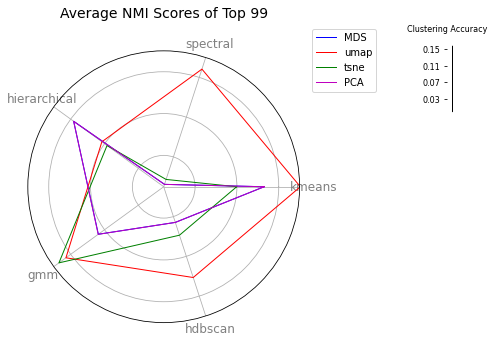

In [10]:
# Call calculate scores function
nmi_scores, ari_scores = calculate_scores(coord_df, ground_truth_labels, n_clusters=2, n_iterations=10)

# Use average nmi scores to make radar plot
plot_radar_chart(nmi_scores)

In [13]:
# Print NMI scores and ARI scores
print('NMI Scores: ')
print(nmi_scores)
print('ARI Scores: ')
print(ari_scores)

NMI Scores: 
{'MDS': {'kmeans': 0.0960501538802836, 'spectral': 0.002382684913395325, 'hierarchical': 0.10649493762361854, 'gmm': 0.07730015800520149, 'hdbscan': 0.03587783154745976}, 'umap': {'kmeans': 0.13073076963628552, 'spectral': 0.11829153694880323, 'hierarchical': 0.07314939164940318, 'gmm': 0.11563692224354394, 'hdbscan': 0.0913061018653554}, 'tsne': {'kmeans': 0.06979774255340712, 'spectral': 0.007348670146496307, 'hierarchical': 0.06703322202719962, 'gmm': 0.12390432122742298, 'hdbscan': 0.04875012375497791}, 'PCA': {'kmeans': 0.0960501538802836, 'spectral': 0.002382684913395325, 'hierarchical': 0.10649493762361854, 'gmm': 0.07747257004627073, 'hdbscan': 0.03587783154745976}}
ARI Scores: 
{'MDS': {'kmeans': 0.07280799752355283, 'spectral': -0.0031918285771405535, 'hierarchical': 0.0794665365406945, 'gmm': -0.06402870219563188, 'hdbscan': 0.0005786904336582569}, 'umap': {'kmeans': 0.06291932777569426, 'spectral': 0.038964033672851874, 'hierarchical': 0.04071564864321433, 'gmm